In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Standard threshold package

### Must run associated queries for updated Income Data and AD Data to ensure payload matching

In [2]:
df = pd.read_csv(r'M:/Risk Management/DW/TUX Scorecard/Prod Testing/NullReplacementLogicTesting/AfterNullReplacementLogicUpdated_11012024-07292025-scoring.csv', dtype={'id': str})


In [3]:
# df = pd.read_excel(r'M:/Risk Management/DW/TUX Scorecard/Prod Testing/NullReplacementLogicTesting/ComparisonFile.xlsx', dtype={'id': str})


In [4]:
df2 = pd.read_excel(r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Auto_Decline_Data_w20.xlsx')


In [5]:
df3 = pd.read_excel(r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Debtor_Data.xlsx')


In [6]:
df4 = pd.read_excel(r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/AppLevelIncomeTUXPayloadTestingData_080625.xlsx')


In [8]:
print(f"Rows in Payload Data {len(df)}")

print(f"Rows in AD Data {len(df2)}")

print(f"Rows in Debtor Data {len(df3)}")

print(f"Rows in Income Data {len(df4)}")

Rows in Payload Data 327261
Rows in AD Data 846387
Rows in Debtor Data 765881
Rows in Income Data 848658


In [9]:
# extract debtorid from id column in df
df['DebtorID'] = df['id'].astype(str).str[7:15]

In [10]:
# df['DebtorID'] = df['DebtorID'].astype(int)
df['DebtorID'] = pd.to_numeric(df['DebtorID'], errors='coerce').astype('Int64')

In [11]:
df3.rename(columns={'bigaccountid': 'AccountId', 'bigdebtorid': 'DebtorId', 'bigDebtorId2': 'DebtorId2'}, inplace=True)

In [12]:
df3['DebtorId'] = df3['DebtorId'].astype('Int64')
df3['DebtorId2'] = df3['DebtorId2'].astype('Int64')

In [13]:
# Merge df with df3 to check for a primary match
df = df.merge(df3[['DebtorId', 'DebtorId2']], how='left', left_on='DebtorID', right_on='DebtorId')

In [14]:
# Merge df again to check for a co-applicant match (ApplicantID == ApplicantId2)
df = df.merge(df3[['DebtorId', 'DebtorId2']], how='left', left_on='DebtorID', right_on='DebtorId2', suffixes=('_primary', '_coapp'))

In [15]:
# Create 'bitPrimary' column
df['bitPrimary'] = df.apply(lambda x: 
    1 if pd.notna(x['DebtorID']) and pd.notna(x['DebtorId_primary']) and x['DebtorID'] == x['DebtorId_primary']
    else (0 if pd.notna(x['DebtorID']) and pd.notna(x['DebtorId2_coapp']) and x['DebtorID'] == x['DebtorId2_coapp']
          else None), axis=1)

In [16]:
print(df['DebtorID'].head())
print(df3['DebtorId'].head())


0    10984121
1    10795943
2    11031132
3    10778774
4    10738517
Name: DebtorID, dtype: Int64
0    10216248
1    10216249
2    10216250
3    10216251
4    10216252
Name: DebtorId, dtype: Int64


In [17]:
# Drop extra columns used for merging
df.drop(columns=['DebtorId2_primary', 'DebtorId_coapp'], inplace=True)

In [18]:
# drop unnecessary columns
df = df.drop(['ErrorMessage', 'SourceFileName', 'id', 'RowId', 'RequestId'], axis=1)

In [19]:
df2.rename(columns={'bigAccountId': 'AccountId'}, inplace=True)

In [20]:
df4.rename(columns={'ACCOUNTID': 'ACCOUNT_ID', 'DBTREMP1_GROSSMONTHLY': 'DebtorTtlIncome', 'CODBTREMP1_GROSSMONTHLY': 'CoDebtorTtlIncome'}, inplace=True)

In [21]:
df4['comb_grossmonthly'] = df4['DebtorTtlIncome'].fillna(0) + df4['CoDebtorTtlIncome'].fillna(0)

In [ ]:
# subset_cols = ['ACCOUNT_ID', 'APPDATE', 'DebtorTtlIncome', 'CoDebtorTtlIncome', 'comb_grossmonthly']
# df4_sub = df4[subset_cols]

In [24]:
df4[['DEBTOR_ID', 'CODEBTOR_ID']] = df4[['DEBTOR_ID', 'CODEBTOR_ID']].astype('Int64')

In [26]:
# Merge df4 onto df using Accountid
df = df.merge(df4[['ACCOUNT_ID', 'DEBTOR_ID', 'DebtorTtlIncome', 'CODEBTOR_ID', 'CoDebtorTtlIncome']], 
                how='left', left_on='AccountId', right_on='ACCOUNT_ID')

# Drop AccountID column from df4 
df.drop(columns=['ACCOUNT_ID'], inplace=True)

In [ ]:
# df2.info()

In [ ]:
# merged_df.info()

In [ ]:
# merged_df = pd.merge(df, df2, on='AccountId', how='left')

In [27]:
df = df.merge(df2[['AccountId', 'dtmStampCreation', 'All_Auto_Declines', 'Conf_Fraud_Declines', 'AD167_Declines', 'MultAuto_Declines', 'ThinFile_Declines', 'BK_Declines', 'MinIncome_Declines']], 
                how='left', left_on='AccountId', right_on='AccountId')


In [ ]:
# merged_df = pd.merge(df, df3, on='AccountId', how='left')

In [29]:
rows_before = df.shape[0]
print(f"Rows before filtering: {rows_before}")

Rows before filtering: 327261


In [30]:
# Filter merged_df to exclude rows where All_AD_rules == 1 and ScoreEcnlMod == 1
final_df = df[
    (df['All_Auto_Declines'] != 1) # & (merged_df['ScoreEcnlMod'] != 1)
]

In [31]:
rows_after = final_df.shape[0]
print(f"Rows after filtering: {rows_after}")

Rows after filtering: 169484


In [ ]:
final_df.info()

In [32]:
# Pivot showing the avg TUX credit score for the bitPrimary pivot table
AvgCrScore_DebtorType = pd.pivot_table(final_df, 
                                    values='CreditEqualizedScore',
                                    index='ApplicantCreditProfileType',
                                    columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCrScore_DebtorType = AvgCrScore_DebtorType.astype(int)

AvgCrScore_DebtorType

bitPrimary,0.0,1.0
ApplicantCreditProfileType,,
OpenBK,694,682
ThickClean,664,664
ThickDirty,646,642
Thin,624,621


In [33]:
# Pivot showing the avg capacity score for the bitPrimary pivot table
AvgCapScore_DebtorType = pd.pivot_table(final_df, 
                                    values='CreditEqualizedScore',
                                    index='ApplicantCreditProfileType',
                                    columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCapScore_DebtorType = AvgCapScore_DebtorType.astype(int)

AvgCapScore_DebtorType

bitPrimary,0.0,1.0
ApplicantCreditProfileType,,
OpenBK,694,682
ThickClean,664,664
ThickDirty,646,642
Thin,624,621


In [34]:
# Pivot showing the avg eq score for the bitPrimary pivot table
AvgEQScore_DebtorType = pd.pivot_table(final_df, 
                                    values='ApplicantScore',
                                    index='ApplicantCreditProfileType',
                                    columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgEQScore_DebtorType = AvgEQScore_DebtorType.astype(int)

AvgEQScore_DebtorType

bitPrimary,0.0,1.0
ApplicantCreditProfileType,,
OpenBK,690,684
ThickClean,661,670
ThickDirty,654,657
Thin,624,632


In [35]:
# Table count and % apps with co-debtors when they are in a different SC than applicant
account_groups = final_df.groupby('AccountId')
multi_applicant_accounts = account_groups.filter(lambda x: len(x) > 1)

# Check if Scorecard is different for applicants
multi_applicant_accounts['Scorecard_diff'] = multi_applicant_accounts.groupby('AccountId')['ApplicantCreditProfileType'].transform('nunique') > 1

# Count how many unique apps are in different scorecards
accounts_with_diff_segments = multi_applicant_accounts[multi_applicant_accounts['Scorecard_diff']]

# Count different scorecard combinations for those accounts
segment_counts = pd.pivot_table(accounts_with_diff_segments,
                                values='AccountId', 
                                index='ApplicantCreditProfileType', 
                                aggfunc='nunique')

# Calculate % of each scorecard in accounts with different segments
total_accounts_with_diff_segments = len(accounts_with_diff_segments['AccountId'].unique())
segment_counts['percentage'] = (segment_counts['AccountId'] / total_accounts_with_diff_segments) * 100

print(segment_counts)

                            AccountId  percentage
ApplicantCreditProfileType                       
OpenBK                            117    1.226158
ThickClean                       5276   55.292392
ThickDirty                       7294   76.440998
Thin                             6397   67.040453


In [36]:
# Check the distribution of 'bitPrimary' across full data set
print(final_df['bitPrimary'].value_counts())

bitPrimary
1.0    146068
0.0     21506
Name: count, dtype: int64


In [39]:
coapp_accounts['bitPrimary'] = coapp_accounts['bitPrimary'].fillna(0).astype(int)


In [40]:
# ID multi-applicant accounts
coapp_accounts = final_df.groupby('AccountId').filter(lambda x: len(x) > 1)

# Check the number of multi-applicant accounts
print(f"Total multi-applicant accounts: {len(coapp_accounts['AccountId'].unique())}")

# If 'bitPrimary' is a string, convert it to integer
coapp_accounts['bitPrimary'] = coapp_accounts['bitPrimary'].astype(int)

# Separate primary applicants (bitPrimary == 1) and coapplicants (bitPrimary == 0)
primary_applicants = coapp_accounts[coapp_accounts['bitPrimary'] == 1]
coapplicants = coapp_accounts[coapp_accounts['bitPrimary'] == 0]

# Check the counts
print(f"Primary applicants count: {len(primary_applicants)}")
print(f"Coapplicants count: {len(coapplicants)}")

Total multi-applicant accounts: 21714


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [41]:
# Show generic distribution % of co-applicants across scorecards

# Merge primary applicants with coapplicants based on AccountId
df_comb_applcnts = primary_applicants[['AccountId', 'ApplicantCreditProfileType']].merge(
    coapplicants[['AccountId', 'ApplicantCreditProfileType']], 
    on='AccountId', 
    suffixes=('_primary', '_coapplicant')
)

# Assign these columns back to merged_df
final_df = final_df.merge(
    df_comb_applcnts[['AccountId', 'ApplicantCreditProfileType_primary', 'ApplicantCreditProfileType_coapplicant']], 
    on='AccountId', 
    how='left'
)


# Filter for cases where the applicants are in different scorecard segments
df_comb_applcnts['different_scorecard'] = df_comb_applcnts['ApplicantCreditProfileType_primary'] != df_comb_applcnts['ApplicantCreditProfileType_coapplicant']

# Filter for cases where the applicants are in different scorecards
different_scorecard_df = df_comb_applcnts[df_comb_applcnts['different_scorecard']]

# Calculate the distribution of coapplicants scorecards
coapplicant_scorecard_distribution = different_scorecard_df['ApplicantCreditProfileType_coapplicant'].value_counts(normalize=True) * 100

# Display the distribution as a percentage
print("Coapplicant Scorecard % Distribution:")
print(coapplicant_scorecard_distribution)


NameError: name 'primary_applicants' is not defined

In [42]:
# Distribution plot of above calc
plt.figure(figsize=(8, 6))
coapplicant_scorecard_distribution.plot(kind='bar', color='skyblue')
plt.title('Coapplicant Scorecard Distribution When Applicants Are in Different Scorecards')
plt.xlabel('Coapplicant Scorecard')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
plt.show()

NameError: name 'coapplicant_scorecard_distribution' is not defined

<Figure size 800x600 with 0 Axes>

In [43]:
# Create crosstab of Applicant Scorecard vs. Coapplicant Scorecard
scorecard_crosstab = pd.crosstab(
    different_scorecard_df['ApplicantCreditProfileType_primary'],  # Rows: Applicant Scorecard
    different_scorecard_df['ApplicantCreditProfileType_coapplicant'],  # Columns: Coapplicant Scorecard
    margins=True  # Adds a total row/column
)

# Normalize by row to show percentages instead of counts
scorecard_percentage_crosstab = pd.crosstab(
    different_scorecard_df['ApplicantCreditProfileType_primary'],  
    different_scorecard_df['ApplicantCreditProfileType_coapplicant'],  
    normalize='index' 
) * 100  


# Graph
plt.figure(figsize=(10, 6))
sns.heatmap(scorecard_percentage_crosstab, annot=True, fmt=".1f", cmap="Blues", linewidths=0.5)

plt.title("Coapplicant Scorecard Distribution by Applicant Scorecard (%)")
plt.xlabel("Coapplicant Scorecard")
plt.ylabel("Applicant Scorecard")
plt.xticks(rotation=45)
plt.show()


NameError: name 'different_scorecard_df' is not defined

In [44]:
# Create a flag for when applicants and coapplicants have the same scorecard
df_comb_applcnts['same_scorecard'] = df_comb_applcnts['ApplicantCreditProfileType_primary'] == df_comb_applcnts['ApplicantCreditProfileType_coapplicant']

# Filter for cases where both applicants are on the same scorecard
same_scorecard_df = df_comb_applcnts[df_comb_applcnts['same_scorecard']]

# Calculate the percentage of applications where coapplicants are on the same scorecard
same_scorecard_percentage = (len(same_scorecard_df) / len(df_comb_applcnts)) * 100

# Print the result
print(f"% of multi-debtor apps where both applicants are on the same scorecard: {same_scorecard_percentage:.2f}%")


NameError: name 'df_comb_applcnts' is not defined

In [45]:
# Prepare data for plotting
scorecard_counts = same_scorecard_df['ApplicantCreditProfileType_coapplicant'].value_counts(normalize=True) * 100

# Print the summary separately
print("Coapplicant Scorecard Distribution (Same Scorecard as Applicant):")
print(scorecard_counts)

# Plot bar chart
plt.figure(figsize=(8, 6))
ax = scorecard_counts.plot(kind='bar', color='lightblue')

# Add data labels to bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',  # Format label as percentage
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position
                ha='center', va='bottom', fontsize=10, fontweight='bold')  # Styling

# Chart labels and title
plt.title('Coapplicant Scorecard Distribution (Same Scorecard as Applicant)')
plt.xlabel('Coapplicant Scorecard')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45)
# plt.ylim(0, 100)  # Set y-axis limits to 100% for better readability

# Show plot
plt.show()



NameError: name 'same_scorecard_df' is not defined

In [46]:
print("Coapplicant Scorecard Distribution (Same Scorecard as Applicant):")
print(scorecard_counts)

Coapplicant Scorecard Distribution (Same Scorecard as Applicant):


NameError: name 'scorecard_counts' is not defined

In [47]:
# Function to create a crosstab heatmap for multiple debtors across scorecard segments
def coapps_scorecard_ct(final_df):
    # Generate the crosstab for primary scorecard vs coapplicant scorecard
    crosstab = pd.crosstab(
        final_df['ApplicantCreditProfileType_primary'], 
        final_df['ApplicantCreditProfileType_coapplicant']
    )
    
    # Convert crosstab counts to percentages of the total
    crosstab_percent = crosstab / crosstab.sum().sum() * 100
    
    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab_percent, annot=True, fmt='.2f', cmap="Blues", linewidths=0.5)
    
    # Titles and labels
    plt.title("Co-Applicant Scorecard Combinations (%)")
    plt.xlabel("Co-Applicant Scorecard Segment")
    plt.ylabel("Applicant Scorecard Segment")
    plt.tight_layout()
    
    # Show plot
    plt.show()

# Call the function on your merged_df
coapps_scorecard_ct(final_df)

KeyError: 'ApplicantCreditProfileType_primary'

In [ ]:
final_df.info()

In [49]:
df_final = final_df.copy()

In [50]:
df_zero_score = df_final[df_final['ApplicationScore'] == 0].copy()
df_scored = df_final[df_final['ApplicationScore'] > 0].copy()

In [51]:
# standard deviation histogram function

def plot_std_histograms(df, score_col, segment_col, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    unique_segments = df[segment_col].unique()
    
    for segment in unique_segments:
        subset = df[df[segment_col] == segment]
        mean = subset[score_col].mean()
        std = subset[score_col].std()
        
        # Calculate standard deviation boundaries and convert to integer
        if pd.notna(mean) and pd.notna(std):
            minus_1_std = int(mean - std)
            plus_1_std = int(mean + std)
            minus_2_std = int(mean - 2 * std)
            plus_2_std = int(mean + 2 * std)
            # Continue plotting
        else:
            print(f"Skipping {segment} due to NaN mean or std.")
            continue
    
        # minus_1_std = int(mean - std)
        # plus_1_std = int(mean + std)
        # minus_2_std = int(mean - 2 * std)
        # plus_2_std = int(mean + 2 * std)
        
        # Define the number of bins manually to control x-axis
        bin_width = (subset[score_col].max() - subset[score_col].min()) / 20
        bins = int((subset[score_col].max() - subset[score_col].min()) / bin_width)

        # Create a new figure
        plt.figure(figsize=(8, 5))
        
        # Plot the histogram with KDE
        sns.histplot(subset[score_col], bins=bins, kde=True, color='royalblue', alpha=0.6)
        
        # Plot mean and standard deviation lines
        line_1 = plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
        line_minus_1_std = plt.axvline(minus_1_std, color='orange', linestyle='dashed', linewidth=2)
        line_plus_1_std = plt.axvline(plus_1_std, color='orange', linestyle='dashed', linewidth=2)
        line_minus_2_std = plt.axvline(minus_2_std, color='green', linestyle='dashed', linewidth=2)
        line_plus_2_std = plt.axvline(plus_2_std, color='green', linestyle='dashed', linewidth=2)

        # Add the lines and their corresponding values in the legend
        plt.legend(
            handles=[line_1, line_plus_1_std, line_minus_1_std, line_plus_2_std, line_minus_2_std],
            labels=[f'Mean (μ): {int(mean)}', f'+1σ: {plus_1_std}', f'-1σ: {minus_1_std}', f'+2σ: {plus_2_std}', f'-2σ: {minus_2_std}'],
            loc='upper right'
        )
        
        # Title and labels
        plt.title(f'Score Distribution for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Save the plot to a file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_std_distribution.png')
        plt.savefig(file_path) 

        plt.show()
        plt.close()

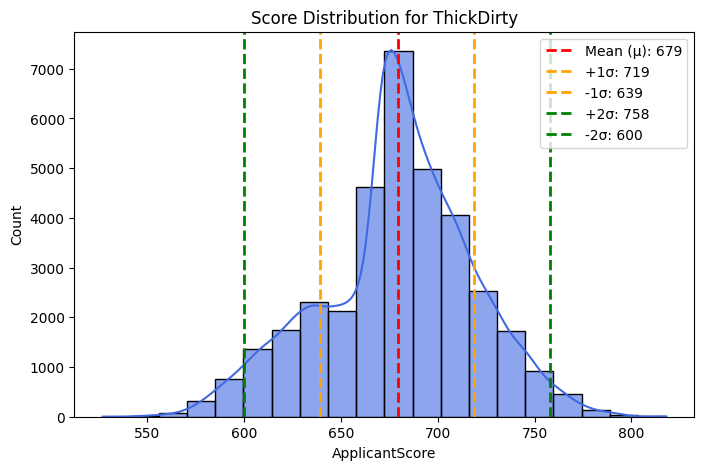

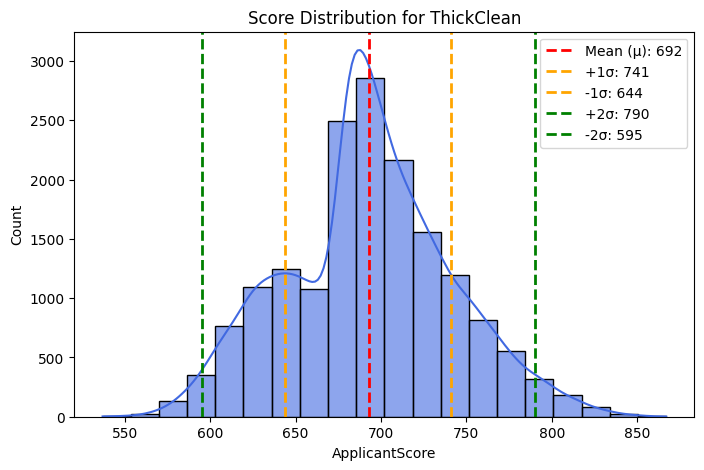

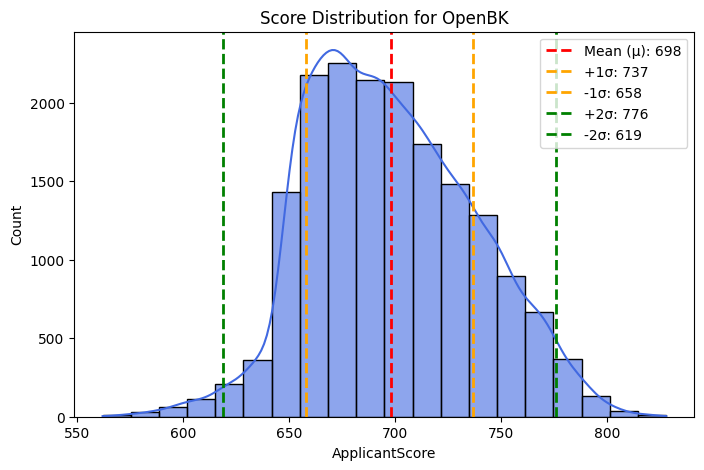

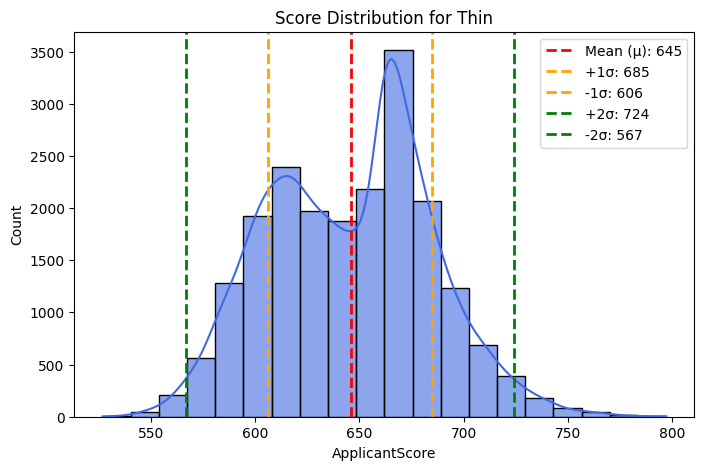

In [52]:
# st. dev histograms on Applicant Score
output_dir = r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/8.6.25FullDebtorPayload/'

plot_std_histograms(df_scored, 'ApplicantScore', 'ApplicantCreditProfileType', output_dir)

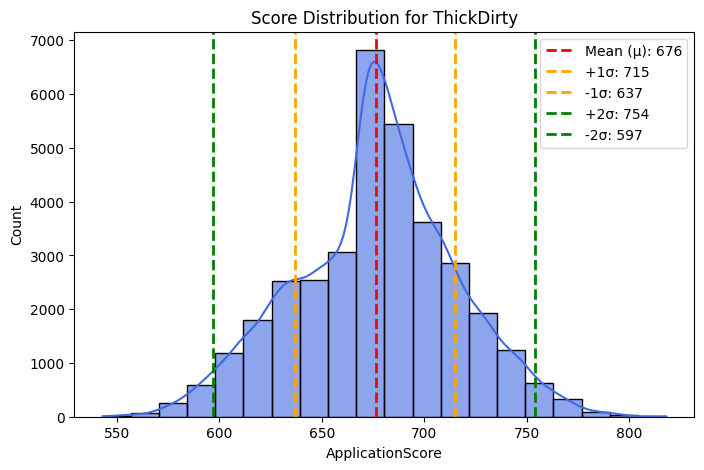

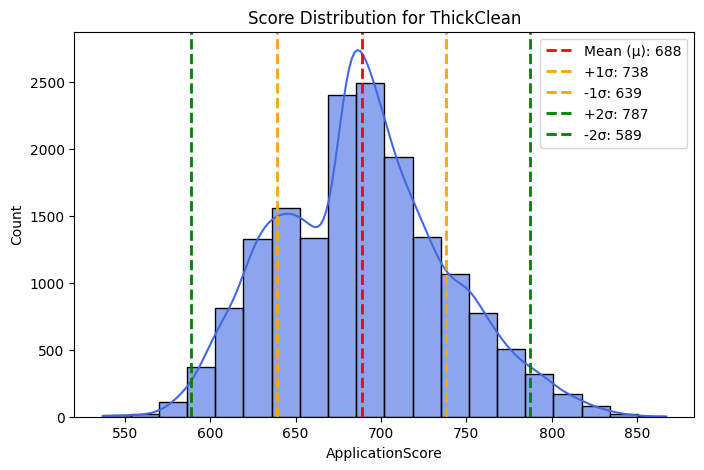

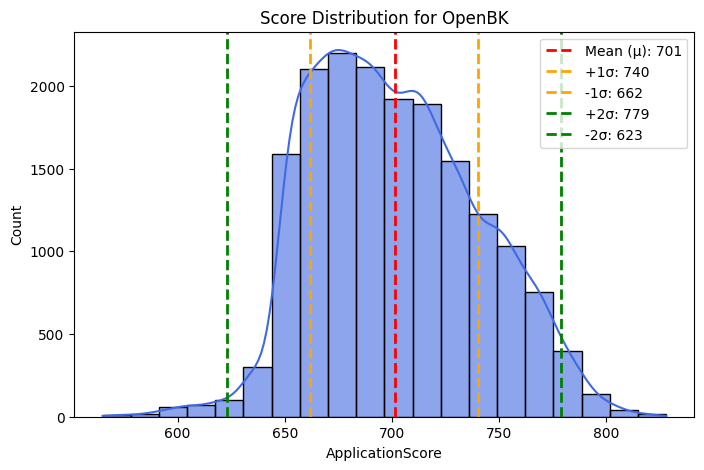

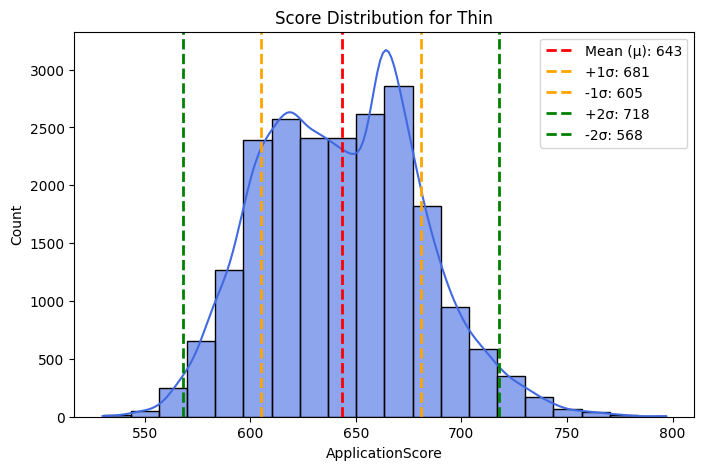

In [53]:
# st. dev histograms on Application Score
output_dir = r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/8.6.25FullDebtorPayload/'

plot_std_histograms(df_scored, 'ApplicationScore', 'ApplicationCreditProfileType', output_dir)

In [54]:
# Decile distribution plots

def plot_segmented_distributions10(df, score_col, segment_col, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store quantiles for each segment
    quantiles = {}
    for segment in df[segment_col].unique():
        quantiles[segment] = df[df[segment_col] == segment][score_col].quantile(
            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # Create a new column to store the quantile categories
    df['EQScore_Quantile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(
            x,
            q=10,
            labels=[
                "Q1 (0-10%)", "Q2 (10-20%)", "Q3 (20-30%)", "Q4 (30-40%)", "Q5 (40-50%)", "Q6 (50-60%)", "Q7 (60-70%)", 
                "Q8 (70-80%)", "Q9 (80-90%)", "Q10 (90-100%)"], duplicates='drop'))

    # Get all unique segment values
    unique_segments = df[segment_col].unique()

    for segment in unique_segments:
        # Filter data for the current segment
        segment_data = df[df[segment_col] == segment]
        
        # Get the quantile values
        quantile_values = quantiles[segment]
        
        # Create the plot
        plt.figure(figsize=(12, 6))
        sns.histplot(segment_data[score_col], bins=20, kde=True, color='royalblue')

        # Plot vertical dashed lines for each quantile (10% to 90%)
        colors = sns.color_palette("husl", 9)
        for idx, q in enumerate(quantile_values.index):
            value = quantile_values[q]
            if pd.notna(value):
                label = f'{int(q*100)}%: {int(value)}'
            else:
                label = f'{int(q*100)}%: n/a'
                value = segment_data[score_col].mean()  # fallback line

            plt.axvline(
                value,
                color=colors[idx % len(colors)],
                linestyle='dashed',
                linewidth=1.5,
                label=label
            )

        # Plot the mean line
        mean = segment_data[score_col].mean()
        # Add a dummy invisible line just for legend
        plt.plot([], [], color='red', linestyle='dashed', linewidth=2, label=f'Mean (μ): {int(mean)}')

        # Add title and axis labels
        plt.title(f'Distribution of {score_col} for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Add legend
        plt.legend(loc='upper right', fontsize='small')
        
        # Save the plot to a file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_distribution10s.png')
        plt.savefig(file_path)
        plt.show()
        plt.close()

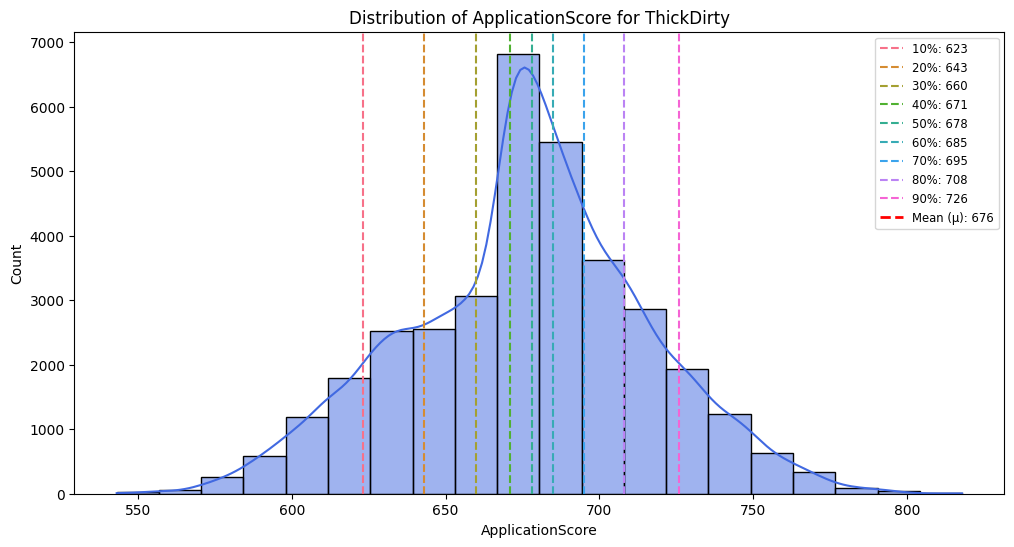

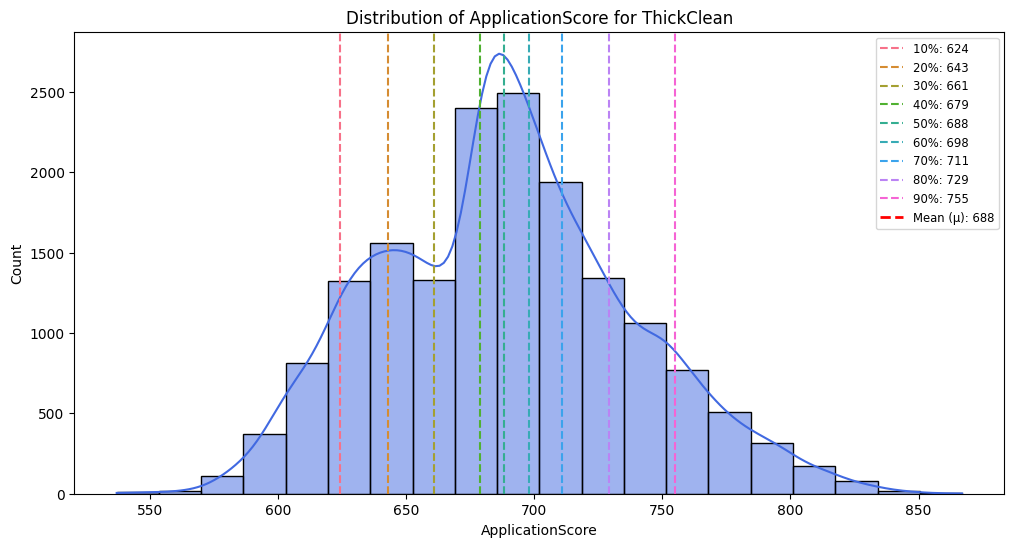

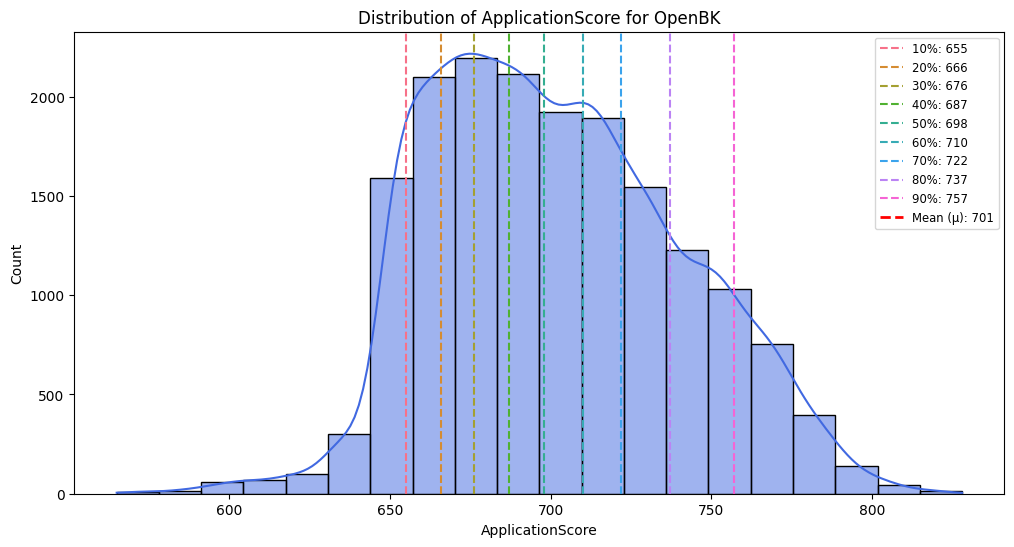

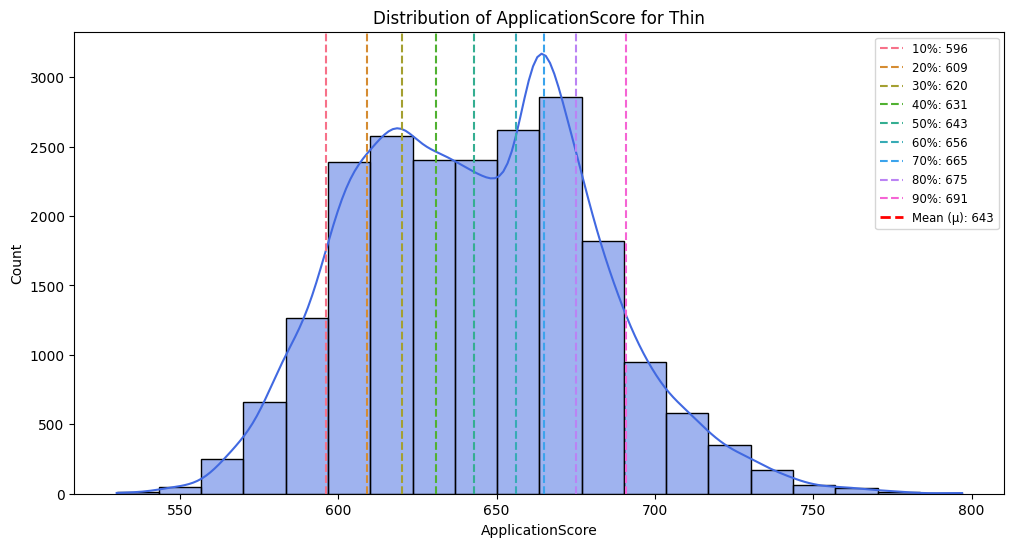

In [55]:
plot_segmented_distributions10(df_scored, 'ApplicationScore', 'ApplicationCreditProfileType', output_dir='M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/8.6.25FullDebtorPayload/')


In [56]:
# 0-score declines per segment
zero_score_summary = df_zero_score.groupby('ApplicationCreditProfileType').size().reset_index(name='ZeroScoreDeclines')
print(zero_score_summary)


  ApplicationCreditProfileType  ZeroScoreDeclines
0                       OpenBK               3793
1                   ThickClean              13969
2                   ThickDirty              32634
3                         Thin              28385


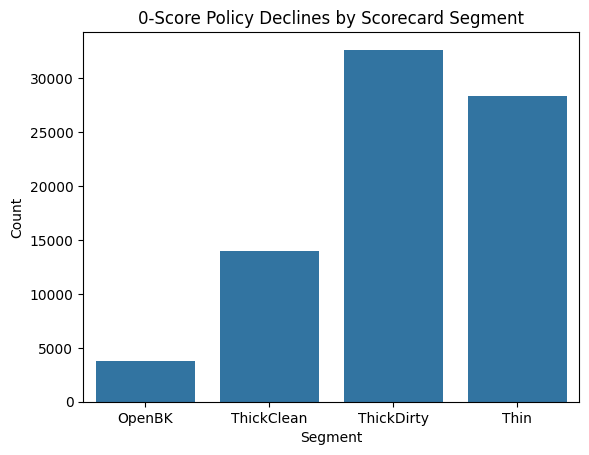

In [57]:
sns.barplot(data=zero_score_summary, x='ApplicationCreditProfileType', y='ZeroScoreDeclines')
plt.title('0-Score Policy Declines by Scorecard Segment')
plt.ylabel('Count')
plt.xlabel('Segment')
plt.show()

# def save_zero_score_barplot(summary_df, output_path):
#     plt.figure(figsize=(10,6))
#     sns.barplot(data=summary_df, x='ApplicationCreditProfileType', y='ZeroScoreDeclines')
#     plt.title('0-Score Policy Declines by Scorecard Segment')
#     plt.ylabel('Count')
#     plt.xlabel('Segment')
#     plt.xticks(rotation=45)
#     plt.tight_layout()
#     plt.savefig(output_path)
#     plt.close()

# # Example usage:
# barplot_path = 'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/zero_score_declines_barplot.png'
# save_zero_score_barplot(zero_score_summary, barplot_path)


In [ ]:
# df_scored.info()

In [58]:
def calculate_decile_summary(df, score_col, segment_col):
    # Dedup records, keeping only applicant level
    df = df[df['bitPrimary'] == 1].copy()
    
    # Define decile labels consistently
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]

    # Assign deciles
    df['EQScore_Decile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(x, q=10, labels=decile_labels, duplicates='drop')
    )

    # Prepare a list to store the summary data
    summary_data = []
    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        for decile in decile_labels:  # Reuse same labels
            decile_data = segment_data[segment_data['EQScore_Decile10'] == decile]
            count = decile_data.shape[0]
            avg_score_mod = round(decile_data['ApplicationProb2Def'].mean(), 4) if not decile_data.empty else None
            summary_data.append([segment, decile, count, avg_score_mod])

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data, columns=[segment_col, 'Decile', 'Count', 'ApplicationProb2Def'])

    # Pivot tables
    count_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='Count', aggfunc='first')
    avg_score_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='ApplicationProb2Def', aggfunc='first')

    return count_table, avg_score_table


In [59]:
# Function to display the tables with simple formatting
def display_tables(count_table, avg_score_table):
    # Print the count table and average score table
    print("Count Table (Applications per Decile):")
    print(count_table.to_string())  # Use .to_string() for better formatting in console
    
    print("\nAverage Score Table (Avg Score per Decile):")
    print(avg_score_table.to_string())  # Print the average score table


In [60]:
def add_decile_ranges(df, score_col, segment_col):
    # Dedup to applicant level rows only
    df = df[df['bitPrimary'] == 1].copy()
    
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]
    ranges = {}

    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        deciles = segment_data[score_col].quantile([i/10 for i in range(1, 10)]).values
        full_deciles = [segment_data[score_col].min()] + list(deciles) + [segment_data[score_col].max()]

        # Assign ranges
        ranges[segment] = {
            decile_labels[i]: (full_deciles[i], full_deciles[i+1]) for i in range(10)
        }

    return ranges

In [61]:
# Call the function to add ranges
ranges = add_decile_ranges(df_scored, 'ApplicationScore', 'ApplicationCreditProfileType')

# Now, print the ranges for each decile
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Decile Ranges for ThickDirty:
D1 (0-10%): 543 - 634
D2 (10-20%): 634 - 660
D3 (20-30%): 660 - 671
D4 (30-40%): 671 - 677
D5 (40-50%): 677 - 683
D6 (50-60%): 683 - 691
D7 (60-70%): 691 - 701
D8 (70-80%): 701 - 712
D9 (80-90%): 712 - 730
D10 (90-100%): 730 - 818

Decile Ranges for OpenBK:
D1 (0-10%): 565 - 656
D2 (10-20%): 656 - 666
D3 (20-30%): 666 - 675
D4 (30-40%): 675 - 686
D5 (40-50%): 686 - 696
D6 (50-60%): 696 - 708
D7 (60-70%): 708 - 720
D8 (70-80%): 720 - 735
D9 (80-90%): 735 - 755
D10 (90-100%): 755 - 828

Decile Ranges for ThickClean:
D1 (0-10%): 537 - 634
D2 (10-20%): 634 - 662
D3 (20-30%): 662 - 680
D4 (30-40%): 680 - 688
D5 (40-50%): 688 - 696
D6 (50-60%): 696 - 706
D7 (60-70%): 706 - 719
D8 (70-80%): 719 - 736
D9 (80-90%): 736 - 760
D10 (90-100%): 760 - 867

Decile Ranges for Thin:
D1 (0-10%): 530 - 601
D2 (10-20%): 601 - 616
D3 (20-30%): 616 - 631
D4 (30-40%): 631 - 647
D5 (40-50%): 647 - 660
D6 (50-60%): 660 - 666
D7 (60-70%): 666 - 673
D8 (70-80%): 673 - 682
D9 (80-90%

In [62]:
# Filter once for application-level view
df_scored_copy = df_scored[df_scored['bitPrimary'] == 1].copy()

# Calculate the decile summaries
count_table, avg_score_table = calculate_decile_summary(df_scored_copy, 'ApplicationScore', 'ApplicationCreditProfileType')

# Display the tables
display_tables(count_table, avg_score_table)

# Get the decile ranges
ranges = add_decile_ranges(df_scored_copy, 'ApplicationScore', 'ApplicationCreditProfileType')

# Print the ranges
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Count Table (Applications per Decile):
Decile                        D1 (0-10%)  D10 (90-100%)  D2 (10-20%)  D3 (20-30%)  D4 (30-40%)  D5 (40-50%)  D6 (50-60%)  D7 (60-70%)  D8 (70-80%)  D9 (80-90%)
ApplicationCreditProfileType                                                                                                                                   
OpenBK                              1612           1457         1436         1409         1595         1407         1554         1432         1511         1429
ThickClean                          1260           1237         1258         1276         1316         1173         1236         1255         1263         1229
ThickDirty                          2742           2628         2609         2794         2753         2487         2734         2748         2502         2679
Thin                                1475           1398         1369         1454         1402         1494         1443         1381         1345         1348



In [63]:
# Generate decile ranges table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)


# Define output filename
output_filename = 'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/8.6.25FullDebtorPayload/App_Level_Thresholds_8.6.25.xlsx'

# # Write to Excel
# with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
#     # Main scored data
#     df_scored.to_excel(writer, index=False, sheet_name='Application Data')
    
#     # Decile ranges
#     ranges_df.to_excel(writer, index=False, sheet_name='Decile Threshold Ranges')
    
#     # Decile count table (wide format, segment x decile)
#     count_table.to_excel(writer, sheet_name='Decile Threshold Counts')
    
#     # Average score/probability table (wide format)
#     avg_score_table.to_excel(writer, sheet_name='Avg Prob2Def')


In [ ]:
# # Assuming output_dir is where your plots are saved
# output_dir = 'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/'

# # First, generate the plots and save them as PNG files
# plot_segmented_distributions10(df_scored_copy, 'ApplicationScore', 'ApplicationCreditProfileType', output_dir)

# # Then, in your Excel writing code:
# with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
#     # Write existing data sheets
#     df_scored.to_excel(writer, index=False, sheet_name='Application Data')
#     ranges_df.to_excel(writer, index=False, sheet_name='Decile Threshold Ranges')
#     count_table.to_excel(writer, sheet_name='Decile Threshold Counts')
#     avg_score_table.to_excel(writer, sheet_name='Avg Prob2Def')

#     # Access the workbook and add a new worksheet for images
#     workbook = writer.book
#     worksheet = workbook.add_worksheet('Decile Distribution Plots')

#     # Insert images in the new sheet
#     # Position images vertically with some spacing
#     row = 0
#     col = 0
#     for segment in df_scored_copy['ApplicationCreditProfileType'].unique():
#         image_path = os.path.join(output_dir, f'{segment}_ApplicationScore_distribution10s.png')
#         if os.path.exists(image_path):
#             # Insert the image at current row and column
#             worksheet.insert_image(row, col, image_path, {'x_scale': 0.75, 'y_scale': 0.75})
#             # Move down to leave space for next image, roughly 20 rows
#             row += 20
#         else:
#             print(f"Warning: Image for segment {segment} not found at {image_path}")


In [ ]:
# # Define your plot output directory (same local path, consistent)

# # Define your output path
# output_dir = 'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/'
# output_filename = os.path.join(output_dir, 'Application_Level_Thresholds_7.29.25.xlsx')

# # Create a new workbook
# wb = Workbook()

# # 0. Write df_scored_Full with proper NA handling
# ws_df = wb.create_sheet(title='df_scored_Full', index=0)

# df_clean = df_scored.reset_index(drop=True).copy()
# df_clean = df_clean.replace({pd.NA: np.nan})
# df_clean = df_clean.where(pd.notnull(df_clean), None)

# for r in dataframe_to_rows(df_clean, index=False, header=True):
#     ws_df.append(r)

# # 1. Decile Threshold Counts
# ws1 = wb.create_sheet('Decile Threshold Counts')
# for r in dataframe_to_rows(count_table.reset_index(), index=False, header=True):
#     ws1.append(r)

# # 2. Avg Prob2Def
# ws2 = wb.create_sheet('Avg Prob2Def')
# for r in dataframe_to_rows(avg_score_table.reset_index(), index=False, header=True):
#     ws2.append(r)

# # 3. Decile Ranges
# ws3 = wb.create_sheet('Decile Threshold Ranges')
# for r in dataframe_to_rows(ranges_df, index=False, header=True):
#     ws3.append(r)

# # 4. Zero Score Declines
# ws4 = wb.create_sheet('Zero Score Declines')
# for r in dataframe_to_rows(zero_score_summary, index=False, header=True):
#     ws4.append(r)

# # 5. Insert Distribution Plots
# ws_img = wb.create_sheet('Decile Distribution Plots')
# row_offset = 1
# for segment in df_scored['ApplicationCreditProfileType'].unique():
#     image_path = os.path.join(output_dir, f'{segment}_ApplicationScore_distribution10s.png')
#     if os.path.exists(image_path):
#         img = OpenpyxlImage(image_path)
#         img.width = int(img.width * 0.75)
#         img.height = int(img.height * 0.75)
#         ws_img.add_image(img, f'A{row_offset}')
#         row_offset += 25
#     else:
#         print(f"⚠️ Image not found for segment: {segment} → {image_path}")

# # 6. Save Workbook
# try:
#     wb.save(output_filename)
#     print(f"✅ Excel workbook saved at: {output_filename}")
# except Exception as e:
#     print(f"❌ Failed to save workbook: {e}")



In [65]:
# Define paths
output_dir = 'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/8.6.25FullDebtorPayload/'
output_filename = os.path.join(output_dir, 'App_Level_Thresholds_8.6.25.xlsx')

# Recompute decile range table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)

# Bar plot: 0-score declines per segment
zero_score_summary = df_zero_score.groupby('ApplicationCreditProfileType').size().reset_index(name='ZeroScoreDeclines')
plot_path = os.path.join(output_dir, 'zero_score_declines.png')
plt.figure(figsize=(8, 5))
sns.barplot(data=zero_score_summary, x='ApplicationCreditProfileType', y='ZeroScoreDeclines')
plt.title('0-Score Policy Declines by Scorecard Segment')
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.savefig(plot_path)
plt.close()

# Write all to Excel using xlsxwriter
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    df_scored.to_excel(writer, sheet_name='df_scored_Full', index=False)
    count_table.to_excel(writer, sheet_name='Decile Threshold Counts')
    avg_score_table.to_excel(writer, sheet_name='Avg Prob2Def')
    ranges_df.to_excel(writer, sheet_name='Decile Threshold Ranges', index=False)
    zero_score_summary.to_excel(writer, sheet_name='Zero Score Declines', index=False)
    
    # If you want, you can include a link or note to the image
    workbook  = writer.book
    worksheet = workbook.add_worksheet('Plot Summary')
    worksheet.write('A1', 'Plot saved separately at:')
    worksheet.write('A2', plot_path)

print(f"Workbook saved: {output_filename}")
print(f"Plot saved: {plot_path}")


Workbook saved: M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/8.6.25FullDebtorPayload/App_Level_Thresholds_8.6.25.xlsx
Plot saved: M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/8.6.25FullDebtorPayload/zero_score_declines.png


In [ ]:
# df_scored.to_excel(r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Large_Payload_Output_wHardcuts_decile.xlsx', index=False)